# Courses recommendation system
# II. Build similarity structures

This is the second part of the Udacity Data Science Nanodegree capstone project, which consists in the creation of a course recommendation system.

<span style="color:red">Once the data is cleaned, the next step is to perform an in-depth analysis. This will facilitate the construction of new structures (if necessary), models and user-item matrices, which will allow me to make recommendations as accurately as possible.</span>

* A course content symilarity matrix to be able to measure the similarity between courses based on their description and title
* A user-item matrix built from leads
* A user-item matrix built from reviews

The information contained in these matrices will be stored in a table format so that it can be consulted quickly in the web application.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sqlalchemy import types as sql_types
from txtools.normalizer import clean_text
from db_utils import connection 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ciscodelgado/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Create a course content similarity matrix

I will create a similarity matrix for courses content. I will use the title and the description to compare the courses with each other. In the matrix, columns and rows indexes will be the course id and the intersection will be the similarity between them. The range of values will be between 0 and 1, where 0 means totally different and 1 means that the content is identical.

In [94]:
def create_similarity_matrix(df, sample_len=None):
    """ 
    Creates a course similarity matrix
    
    :param df DataFrame: courses dataframe. Must include title and description columns
                          
    :return np.ndarray: An m x m matrix representing the course similarities, where m is the number of courses.
        Example of a similarity matrix:
        
         [[0.99999994 0.         0.13075474 0.02665992]
          [0.         1.         0.00812627 0.00331377]
          [0.13075474 0.00812627 1.         0.0069054 ]
          [0.02665992 0.00331377 0.0069054  1.        ]]
          
        rows and columns represents a course, the elements in the matrix, represent the similarity between them.
    """
    if not sample_len:
        course_content = df['title'].str.cat(df['description'], sep=' ').values
    else:
        course_content = df['title'].str.cat(df['description'], sep=' ').head(sample_len).values
    
    model = Pipeline([
        ('norm', TextNormalizer()),
        ('sim', Similarity())
    ])
    
    return model.fit_transform(course_content)
    
    
def create_similarity_df(df, min_similarity=0.5, sample_len=None):
    """
    Creates a course similarity DataFrame from a similarity matrix
    
    :param df DataFrame: Courses dataframe. Must include title and description columns
    :param min_similarity float: Minimum similarity to be included in DataFrame
    :param sample_len int: Maximum number of courses that will be included in the matrix
    
    :return DataFrame: a dataframe with following columns:
        a_course str: course id
        another_course str: course id
        similarity float: similarity between courses
    """
    sim_list = []
    sim_matrix = create_similarity_matrix(df, sample_len=sample_len)
    
    for idx, similarities in enumerate(sim_matrix):
        a_course_id = df.iloc[idx]['course_id']
        
        for idx_sims, sim_score in enumerate(similarities):
            if idx == idx_sims:
                continue

            if sim_score < min_similarity:
                continue

            another_course_id = df.iloc[idx_sims]['course_id']

            sim_list.append({'a_course_id': a_course_id, 
                             'another_course_id': another_course_id, 
                             'similarity': sim_score})

    return pd.DataFrame(sim_list)

I will create a similarity matrix with a sample of 50 courses

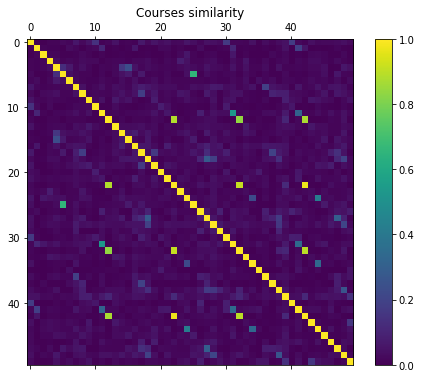

In [96]:
sims = create_similarity_matrix(courses_df, sample_len=50)

fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(sims, interpolation='nearest')
fig.colorbar(cax)
ax.set_title('Courses similarity')

plt.show();

The similarity dataframe will look like this:

In [97]:
sims_df_s50 = create_similarity_df(courses_df, sample_len=50)
sims_df_s50.head()

,a_course,another_course,similarity
0,170628400,170628401,0.658486
1,170040323,170040270,0.528053
2,170633067,170633063,0.882820
3,170633067,170633065,0.837449
4,170633067,170633072,0.871613


And now, I will create the similarities dataframe with the entire courses dataframe. <span style="color:red">**This process took approximately 8 hours on a MacBook pro (2.3 GHz Intel Core i5, 16 GB RAM)**</span>

In [ ]:
%%time
sims_df = create_similarity_df(courses_df)

In [31]:
sims_df.head()

,a_course,another_course,similarity
0,170648149,170648146,0.996332
1,170648149,170652710,0.505740
2,170367782,170642187,0.539035
3,170367782,170624005,0.557652
4,170601656,170617492,0.500261


In [ ]:
sims_df.to_csv('../data/courses_similarities.csv', index=False)

In [610]:
sims_df = pd.read_csv('../data/courses_similarities.csv')

In [614]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `courses_similarities`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `courses_similarities` (
  `a_course_id` varchar(9) NOT NULL,
  `another_course_id` varchar(9) NOT NULL,
  `similarity` double NOT NULL,
  PRIMARY KEY (`a_course_id`, `another_course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save course similarities to database
sims_df.to_sql('courses_similarities', con=conn, if_exists='append', index=False)

/Users/ciscodelgado/anaconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1051, "Unknown table 'heroku_8149febc614deb5.courses_similarities'")
  result = self._query(query)


## Create the user item matrices

<span style="color:red">Docstring to be completed</span>

In [288]:
def create_user_item_matrix(df, group_columns=['user_id', 'course_id'], select_column='rating', allow_nulls=True):
    """
    Creates a user-item matrix DataFrame. Depending on the dataframe supplied it creates a
    user-item matrix from reviews of from leads
    
    :param group_columns list: Columns by which the data will be grouped
    :param select_column str: 
    :param allow_nulls bool: 
    
    :return DataFrame: a user-item matrix dataframe
    """
    columns = [column for column in group_columns]
    if select_column not in group_columns:
        columns.extend([select_column])
    
    user_items = df[columns]
    
    user_by_course = user_items.groupby(group_columns)[select_column].max().unstack()
    
    if not allow_nulls:
        user_by_course = user_by_course.where(user_by_course.isnull(), other=1)
        user_by_course = user_by_course.fillna(0)
    
    return user_by_course

In [289]:
ratings_user_item_matrix = create_user_item_matrix(reviews_df)
leads_user_item_matrix = create_user_item_matrix(leads_df, select_column='course_id', allow_nulls=False)

Save the matrices to csv files

In [290]:
leads_user_item_matrix.to_csv('../data/leads_matrix.csv')
ratings_user_item_matrix.to_csv('../data/ratings_matrix.csv')

In [467]:
from scipy.sparse import csr_matrix

In [542]:
occurrences = csr_matrix(leads_user_item_matrix, dtype='int8')
occurrences

<26974x10984 sparse matrix of type '<class 'numpy.int8'>'
	with 38602 stored elements in Compressed Sparse Row format>

In [543]:
from sklearn.preprocessing import normalize

normalized = normalize(occurrences, axis=0)
user_similarities = normalized.transpose().dot(normalized)
user_similarities.setdiag(0)

In [517]:
user_similarities = occurrences.transpose().dot(occurrences)
user_similarities.setdiag(0)

In [545]:
coo = user_similarities.tocoo()
coo

<10984x10984 sparse matrix of type '<class 'numpy.float64'>'
	with 54076 stored elements in COOrdinate format>

In [604]:
user_similarities_df = pd.DataFrame([[leads_user_item_matrix.index[a_user], leads_user_item_matrix.index[another_user], similarity] 
                                    for a_user, another_user, similarity in zip(coo.row, coo.col, coo.data)
                                    if similarity >= 0.5])
user_similarities_df.columns = ['a_user_id', 'another_user_id', 'similarity']

In [608]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `users_similarities`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `users_similarities` (
  `a_user_id` char(36) NOT NULL,
  `another_user_id` char(36) NOT NULL,
  `similarity` double NOT NULL,
  PRIMARY KEY (`a_user_id`, `another_user_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save user similarities to database
user_similarities_df.to_sql('users_similarities', con=conn, if_exists='append', index=False)

## Create user interactions dictionaries

<span style="color:red">
I will create two dictionaries with users interactions; a leads generated dictionary in which the keys will be the user ids and the values will be lists of courses that lead has generated.</span>

In [291]:
def create_user_leads_generated_dict():
    """
    Creates a dictionary with users as keys and lists of courses in which each user has generated lead
    
    :return dict: User-courses dictionary
    """
    leads_generated = dict()
    
    for user_id, _ in leads_user_item_matrix.iterrows():
        user_courses = leads_user_item_matrix.loc[user_id]
        leads_generated[user_id] = user_courses[leads_user_item_matrix.loc[user_id] == 1].index.values
        
    return leads_generated


def create_user_ratings_dict(min_num_rated=2):
    """
    Creates a dictionary with users as keys and lists of courses each user has rated
    
    :param int: minimum number of courses rated by user to be included in the dictionary
    
    :return dict: User-courses dictionary
    """
    ratings = dict()
    
    for user_id, _ in ratings_user_item_matrix.iterrows():
        user_courses = ratings_user_item_matrix.loc[user_id]
        user_ratings = user_courses[user_courses.notnull()].index.values
        if len(user_ratings) < min_num_rated:
            continue
            
        ratings[user_id] = user_ratings
        
    return ratings

Save the dictionaries to pickle files

In [292]:
rated_courses = create_user_ratings_dict()
with open('../data/rated_courses.pickle', 'wb') as handle:
    pickle.dump(rated_courses, handle)

generated_leads = create_user_leads_generated_dict()
with open('../data/generated_leads.pickle', 'wb') as handle:
    pickle.dump(generated_leads, handle)

## Create a users distance score table

In [293]:
def compute_euclidean_distance(a_user_id, another_user_id, user_item_matrix):
    """
    Computes the euclidean distance between users taking into account the rated courses
    
    :param a_user_id str: Id of a user
    :param another_user_id str: Id of another user
    :param user_item_matrix DataFrame: The reviews user-item matrix
    
    :return float: The eculidean distance between the users
    """
    a_user_courses = rated_courses[a_user_id]
    another_user_courses = rated_courses[another_user_id]
    
    similar_courses = np.intersect1d(a_user_courses,
                                     another_user_courses, 
                                     assume_unique=True)
    
    # there's no courses in common
    if len(similar_courses) == 0:
        return np.nan
    
    df = user_item_matrix.loc[(a_user_id, another_user_id), similar_courses]
    
    return np.linalg.norm(df.loc[a_user_id] - df.loc[another_user_id])


def create_distances_dataframe(user_item_matrix):
    """
    Creates a dataframe containing the euclidean distances between users
    
    :param user_item_matrix DataFrame: The ratings user-item matrix
    
    :return DataFrame: DataFrame containing the eculidean distances between the users
    """
    users = user_item_matrix.index.values
    distances = []

    for a_user_id in users:
        for another_user_id in users:
            if a_user_id == another_user_id:
                continue
            try: 
                distance = compute_euclidean_distance(a_user_id,
                                                      another_user_id,
                                                      ratings_user_item_matrix)
            except KeyError:
                continue

            if np.isnan(distance):
                continue

            distances.append({'a_user': a_user_id,
                              'another_user': another_user_id,
                              'eucl_dist': distance})

    return pd.DataFrame.from_dict(distances)

In [294]:
distances_df = create_distances_dataframe(ratings_user_item_matrix)

# Save the users distances to a pickle file
distances_df.to_pickle('../data/users_distances.pickle')
distances_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
a_user          22 non-null object
another_user    22 non-null object
eucl_dist       22 non-null float64
dtypes: float64(1), object(2)
memory usage: 608.0+ bytes


In [295]:
distances_df['eucl_dist'].value_counts()

0.000000    14
4.000000     4
2.828427     2
5.656854     2
Name: eucl_dist, dtype: int64

In [296]:
distances_df.shape

(22, 3)